In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
#자연발생 클러스터링(민원 단계 컬럼 생성)
from jenkspy import JenksNaturalBreaks

parks_df = pd.read_csv("src/RF_parksdf_week.csv")
#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")

# 1) IQR 계산
Q1 = parks_df["complaints_r300"].quantile(0.25)
Q3 = parks_df["complaints_r300"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2) 이상치 제거
parks_df = parks_df[
    (parks_df["complaints_r300"] >= lower_bound) &
    (parks_df["complaints_r300"] <= upper_bound)
].copy()

# 3) 필터된 데이터로 Jenks 적용
i = 3
breaks = JenksNaturalBreaks(n_classes=i)
breaks.fit(parks_df["complaints_r300"])
print("경계값:", breaks.breaks_)

# 4) 레이블 부여
parks_df["complaint_level"] = pd.cut(
    parks_df["complaints_r300"],
    bins=breaks.breaks_,
    labels=range(i),
    include_lowest=True
)
parks_df["complaint_level"].value_counts()

경계값: [0, 913, 2107, 4099]


complaint_level
0    800
1    459
2    273
Name: count, dtype: int64

In [3]:
print(parks_df.columns)

Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Weekday_paid', 'Weekday_start', 'Weekday_end',
       'Weekday_operatingHours', 'lon', 'lat', 'complaint_level'],
      dtype='object')


In [4]:
'''# KMeans 기반 클러스터링

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

parks_df = pd.read_csv("src/RF_parksdf_week.csv")
#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")
parks_df.columns

# 1) IQR 계산
Q1 = parks_df["complaints_r300"].quantile(0.25)
Q3 = parks_df["complaints_r300"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2) 이상치 제거
parks_df = parks_df[
    (parks_df["complaints_r300"] >= lower_bound) &
    (parks_df["complaints_r300"] <= upper_bound)
].copy()

k = 3

X = parks_df["complaints_r300"].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_.flatten()
sorted_idx = np.argsort(centers)
label_map = {old: new for new, old in enumerate(sorted_idx)}
sorted_labels = np.vectorize(label_map.get)(clusters)

parks_df["complaint_level"] = sorted_labels

parks_df["complaint_level"].value_counts().sort_index()
'''

'# KMeans 기반 클러스터링\n\nfrom sklearn.cluster import KMeans\nimport numpy as np\nimport pandas as pd\n\nparks_df = pd.read_csv("src/RF_parksdf_week.csv")\n#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")\n#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")\nparks_df.columns\n\n# 1) IQR 계산\nQ1 = parks_df["complaints_r300"].quantile(0.25)\nQ3 = parks_df["complaints_r300"].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# 2) 이상치 제거\nparks_df = parks_df[\n    (parks_df["complaints_r300"] >= lower_bound) &\n    (parks_df["complaints_r300"] <= upper_bound)\n].copy()\n\nk = 3\n\nX = parks_df["complaints_r300"].values.reshape(-1, 1)\n\nkmeans = KMeans(n_clusters=k, random_state=0)\nclusters = kmeans.fit_predict(X)\n\ncenters = kmeans.cluster_centers_.flatten()\nsorted_idx = np.argsort(centers)\nlabel_map = {old: new for new, old in enumerate(sorted_idx)}\nsorted_labels = np.vectorize(label_map.get)(clusters)\n\nparks_df["complaint_level"] = sorted_labe

In [5]:
#범주형 변수의 label을 [0,1]로 변환
from sklearn.preprocessing import LabelEncoder

le_dict = {}

for col in ["parking_type", "operation_type", "Weekday_paid", "Saturday_paid", "Holiday_paid"]:
    if col in parks_df.columns:  # ✅ 존재하는 경우에만 처리
        le = LabelEncoder()
        parks_df[col] = le.fit_transform(parks_df[col])
        le_dict[col] = le

# 예시: parking_type의 범주와 정수 매핑 확인
for col in le_dict:
    print(f"{col}: {list(le_dict[col].classes_)}")

# [0, 1, 2, ...] 순서로 classes_에 저장됨
#['NS', 'NW'] -> [0,1]
#[1, 3] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]

parking_type: ['NS', 'NW']
operation_type: [1, 3]
Weekday_paid: ['N', 'Y']


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# 0) 데이터 준비axis=
X = parks_df.drop(["complaints_r300", "complaint_level", "address", "lat", "lon",
                   "base_parking_fee", "base_parking_time", "additional_unit_fee", "additional_unit_time"], axis=1)
y = parks_df["complaint_level"]

# 1) 80%를 train+val, 20%를 test로 분리 (stratify 유지)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2) train_val(80%) 중 12.5%를 val로 → 전체 비율 10%, train은 70%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.125,    # 0.8 * 0.125 = 0.1
    stratify=y_train_val,
    random_state=42
)

# 3) 훈련셋에서만 RandomForest로 피처 중요도 계산
rf_fs = RandomForestClassifier(random_state=0)
rf_fs.fit(X_train, y_train)

importances = pd.Series(rf_fs.feature_importances_, index=X_train.columns)
top10 = importances.nlargest(7).index.tolist()
print("선택된 상위 10개 피처:", top10)

# 4) 선택된 피처로 데이터 재정의
X_train_sel = X_train[top10]
X_val_sel   = X_val[top10]
X_test_sel  = X_test[top10]

# 5) 최종 모델 학습 & 평가
rf = RandomForestClassifier(
    random_state=0,
    class_weight="balanced"   # 클래스 불균형 보정
)
rf.fit(X_train_sel, y_train)

val_pred  = rf.predict(X_val_sel)
test_pred = rf.predict(X_test_sel)

print("Validation 정확도: {:.4f}".format(accuracy_score(y_val, val_pred)))
print("Test 정확도      : {:.4f}".format(accuracy_score(y_test, test_pred)))


선택된 상위 10개 피처: ['total_parking_spaces', 'bus_r300', 'fee1H', 'cctv_r300', 'Weekday_end', 'Weekday_operatingHours', 'Weekday_start']
Validation 정확도: 0.6429
Test 정확도      : 0.7264


In [7]:
# Accuracy 분석

from sklearn.metrics import classification_report, accuracy_score

print("Complaint Level (Kmeans) Classification Accuracy:", round(accuracy_score(y_test, test_pred), 3))
print(classification_report(y_test, test_pred, target_names=['Low', 'Mid', 'High']))

Complaint Level (Kmeans) Classification Accuracy: 0.726
              precision    recall  f1-score   support

         Low       0.82      0.86      0.84       160
         Mid       0.62      0.59      0.60        92
        High       0.61      0.56      0.58        55

    accuracy                           0.73       307
   macro avg       0.68      0.67      0.68       307
weighted avg       0.72      0.73      0.72       307



In [8]:
'''
X = parks_df.drop(["complaints_r300", "complaint_level", "address"], axis=1)
y = parks_df["complaint_level"]

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_full = RandomForestClassifier(random_state=0)
rf_full.fit(X_train_full, y_train)

# 중요도 기반 상위 10개 변수 선택
importances = pd.Series(rf_full.feature_importances_, index=X.columns)
top10_features = importances.sort_values(ascending=False).head(9).index.tolist()

X_new = X[top10_features]

print("X_new 변수 목록:", top10_features)
'''

'\nX = parks_df.drop(["complaints_r300", "complaint_level", "address"], axis=1)\ny = parks_df["complaint_level"]\n\nX_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)\nrf_full = RandomForestClassifier(random_state=0)\nrf_full.fit(X_train_full, y_train)\n\n# 중요도 기반 상위 10개 변수 선택\nimportances = pd.Series(rf_full.feature_importances_, index=X.columns)\ntop10_features = importances.sort_values(ascending=False).head(9).index.tolist()\n\nX_new = X[top10_features]\n\nprint("X_new 변수 목록:", top10_features)\n'

In [9]:
'''
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state = 42)

X_new.columns
'''

'\nX_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.1, random_state = 42)\nX_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state = 42)\n\nX_new.columns\n'

In [10]:
'''
# 랜덤포레스트 
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))
'''

"\n# 랜덤포레스트 \nrf = RandomForestClassifier(random_state=0)\nrf.fit(X_train, y_train)\npred = rf.predict(X_test)\naccuracy = accuracy_score(y_test, pred)\nprint('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))\n"

In [11]:
'''
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('gradient boosting 정확도: {:.4f}'.format(accuracy))
'''

"\n# gradient boosting\nfrom sklearn.ensemble import GradientBoostingClassifier\n\ngb = GradientBoostingClassifier(random_state=0)\ngb.fit(X_train, y_train)\npred = gb.predict(X_test)\naccuracy = accuracy_score(y_test, pred)\nprint('gradient boosting 정확도: {:.4f}'.format(accuracy))\n"

In [12]:
importances = rf.feature_importances_
feature_names = top10  # DataFrame에서 feature 이름 추출

# 중요도 표 만들기
importance_table = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

importance_table


,feature,importance
0,total_parking_spaces,0.238468
1,bus_r300,0.200366
2,fee1H,0.185563
3,cctv_r300,0.162077
4,Weekday_end,0.092352
5,Weekday_operatingHours,0.072580
6,Weekday_start,0.048594


In [13]:
from sklearn.metrics import mean_squared_error
import pandas as pd
pd.set_option('display.max_rows', None)

# 여기 요일타입에 따라 바꿔야 됩니다!!
dong_parks_df = pd.read_csv("src/dongParks_Weekday.csv")

dong_parks_df

# dong_parks_df의 feature 컬럼만 추출 (dong 이름 등 식별자 제외)
# 모델이 학습할 때 사용한 feature 리스트
model_features = list(rf.feature_names_in_)

# dong_parks_df에서 해당 컬럼만 추출
X_dong = dong_parks_df[model_features]
# 동별 민원 수준 예측
dong_parks_df['predicted_complaints'] = rf.predict(X_dong)

# 그룹별 동 이름 추출
high_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 2]['dong']
mid_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 1]['dong']
low_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 0]['dong']

# 각 그룹을 DataFrame으로 변환 (인덱스 리셋)
high_df = pd.DataFrame({'High 민원': high_dong.reset_index(drop=True)})
mid_df = pd.DataFrame({'Mid 민원': mid_dong.reset_index(drop=True)})
low_df = pd.DataFrame({'Low 민원': low_dong.reset_index(drop=True)})

# 길이가 다른 경우도 맞춰서 하나의 표로 합치기
dong_table = pd.concat([high_df, mid_df, low_df], axis=1)

from IPython.display import display
display(dong_table.head())

,High 민원,Mid 민원,Low 민원
0,가락본동,가리봉동,가산동
1,고덕2동,강일동,가양1동
2,구로3동,개포3동,가양2동
3,구로4동,개포4동,가양3동
4,구로5동,거여2동,갈현1동


In [14]:
import pandas as pd

pd.Series(rf.feature_importances_, index=X_dong.columns).sort_values(ascending=False)

total_parking_spaces      0.238468
bus_r300                  0.200366
fee1H                     0.185563
cctv_r300                 0.162077
Weekday_end               0.092352
Weekday_operatingHours    0.072580
Weekday_start             0.048594
dtype: float64

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_dong),
    columns=X_dong.columns
)

'''
# 정규화 수행
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_dong), columns=X_dong.columns)
'''

# 정규화된 데이터 기준으로 영향력 큰 feature 추정
importances = rf.feature_importances_
dong_parks_df['top_feature'] = X_scaled.apply(
    lambda row: row.index[np.argmax(np.abs(row.values * importances))],
    axis=1
)

# 결과 출력
solution_table = dong_parks_df[['dong', 'predicted_complaints', 'top_feature']]
display(solution_table.head())

# 민원 수준별 요약
summary = solution_table.groupby('predicted_complaints')['top_feature'].value_counts()
print(summary)


,dong,predicted_complaints,top_feature
0,가락본동,2,cctv_r300
1,가리봉동,1,total_parking_spaces
2,가산동,0,bus_r300
3,가양1동,0,total_parking_spaces
4,가양2동,0,bus_r300


predicted_complaints  top_feature         
0                     fee1H                   48
                      bus_r300                47
                      total_parking_spaces    46
                      cctv_r300               25
                      Weekday_end              1
1                     fee1H                   33
                      cctv_r300               17
                      bus_r300                16
                      total_parking_spaces    13
2                     cctv_r300               24
                      total_parking_spaces    20
                      fee1H                   16
                      bus_r300                15
Name: count, dtype: int64


In [20]:
print(parks_gdf.columns)

Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Weekday_paid', 'Weekday_start', 'Weekday_end',
       'Weekday_operatingHours', 'lon', 'lat', 'complaint_level', 'dong'],
      dtype='object')


In [ ]:
'''
import pandas as pd

# 1) RF 데이터 읽기
rf = pd.read_csv("src/RF_parksdf_holi.csv")

# 2) 위도·경도 데이터 읽고 주소 칼럼명 통일
parks = pd.read_csv("src/parks_Holiday.csv")
parks = parks.rename(columns={"주소": "address"})

# 3) address 기준으로 병합 (left join)
merged = pd.merge(
    rf,
    parks[["address", "lon", "lat"]],  # 필요한 칼럼만
    on="address",
    how="left"
)

# 4) 결과 저장
merged.to_csv("src/RF_parksdf_holi.csv", index=False)
'''


In [17]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 1) 행정동 경계 불러오기 (EPSG:5179)
dong_boundaries = (
    gpd.read_file("src/dong_boundary.shp")
       .rename(columns={"ADM_NM":"dong"})
)

# 3) 주소에서 ‘○○동’ 부분만 추출해 두기
parks_df['addr_dong'] = parks_df['address'].str.extract(r'^\S+\s+(\S+동)')[0]

# 4) GeoDataFrame 생성 (위경도 → EPSG:4326 지정)
geometry = [Point(xy) for xy in zip(parks_df['lon'], parks_df['lat'])]
parks_gdf = gpd.GeoDataFrame(
    parks_df,
    geometry=geometry,
    crs="EPSG:4326"
)

# 5) 경계 CRS로 투영
parks_gdf = parks_gdf.to_crs(dong_boundaries.crs)

# ─────── 이 부분을 추가 ───────
# 6) 공간 결합
parks_gdf = gpd.sjoin(
    parks_gdf,
    dong_boundaries[['dong','geometry']],
    how='left',
    predicate='within'
)

# 7) NaN인 경우만 매핑 테이블로 보정
mapping = {
    '잠실동': '잠실본동',
    # 필요시 다른 주소-행정동도 여기에 추가
}
parks_gdf['dong'] = parks_gdf['dong'].fillna(
    parks_gdf['addr_dong'].map(mapping)
)
# ─────────────────────────────

# 8) 결과 확인
parks_gdf = parks_gdf.drop(columns=['addr_dong', 'geometry', 'index_right'])
print(parks_gdf.columns)


Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Weekday_paid', 'Weekday_start', 'Weekday_end',
       'Weekday_operatingHours', 'lon', 'lat', 'complaint_level', 'dong'],
      dtype='object')


In [18]:
import numpy as np
import pandas as pd
import shap

# 1) TreeExplainer 생성
explainer = shap.TreeExplainer(rf)
feature_cols = list(rf.feature_names_in_)

# 2) park-level SHAP 값 계산 (n_samples, n_features, n_classes)
raw_shap_p = explainer.shap_values(parks_gdf[feature_cols])

# 3) 클래스 차원 절댓값 평균 → (n_samples, n_features)
shap_abs_p = np.abs(raw_shap_p).mean(axis=2)

# 4) DataFrame으로 변환 후 dong 매핑
df_shap_p        = pd.DataFrame(shap_abs_p, columns=feature_cols)
df_shap_p['dong'] = parks_gdf['dong'].values

# 5) 행정동별 평균 SHAP 기여도 집계
dong_shap_mean = df_shap_p.groupby('dong').mean()

# 6) 행정동별 Top3 피처 추출
top3 = dong_shap_mean.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
df_top3 = (
    pd.DataFrame(top3.tolist(), index=top3.index, columns=['Top1','Top2','Top3'])
      .reset_index()
      .rename(columns={'index':'dong'})
)

# 7) 결과 확인
print(df_top3.head())


   dong                  Top1           Top2                    Top3
0  가락본동           Weekday_end          fee1H           Weekday_start
1  가리봉동             cctv_r300    Weekday_end    total_parking_spaces
2   가산동           Weekday_end  Weekday_start  Weekday_operatingHours
3  가양1동                 fee1H      cctv_r300    total_parking_spaces
4  가양2동  total_parking_spaces       bus_r300           Weekday_start


In [ ]:
# 1) 실제 complaints_level: parks_gdf 에 이미 있다면 바로 사용
#    없다면, 원본 complaints_df 등에서 행정동별로 집계해서 merge

# 예: 원본 parks_df 에 'complaints_level' 컬럼이 있다고 가정
actual = parks_gdf.groupby('dong')['complaint_level'] \
                   .agg(lambda x: x.mode()[0]) \
                   .reset_index()

# 2) 예측 complaints_level
predicted = pd.DataFrame({
    'dong': parks_gdf['dong'],
    'predicted_level': rf.predict(parks_gdf[feature_cols])
}).groupby('dong')['predicted_level'] \
  .agg(lambda x: x.mode()[0]) \
  .reset_index()

# 3) df_top3 에 결합
df_insight = (
    df_top3
      .merge(actual,    on='dong', how='left')
      .merge(predicted, on='dong', how='left')
)

df_insight.head()


,dong,Top1,Top2,Top3,complaint_level,predicted_level
0,가락본동,Weekday_end,fee1H,Weekday_start,2,2
1,가리봉동,cctv_r300,Weekday_end,total_parking_spaces,1,1
2,가산동,Weekday_end,Weekday_start,Weekday_operatingHours,0,0
3,가양1동,fee1H,cctv_r300,total_parking_spaces,0,0
4,가양2동,total_parking_spaces,bus_r300,Weekday_start,0,0
5,가양3동,total_parking_spaces,cctv_r300,Weekday_end,0,0
6,갈현1동,cctv_r300,fee1H,bus_r300,0,0
7,강일동,bus_r300,Weekday_end,fee1H,1,1
8,개봉1동,cctv_r300,fee1H,Weekday_end,0,0
9,개포1동,cctv_r300,total_parking_spaces,bus_r300,0,0


In [91]:
######

In [73]:
import shap
import matplotlib.pyplot as plt

# 1. feature 컬럼만 추출 (dong 등 식별자 제외)
feature_cols = [col for col in dong_parks_df.columns if col not in [
    'dong', 'complaint_level','predicted_complaints' 
]]

high_dong_df = dong_parks_df[dong_parks_df['predicted_complaints']==2]
mid_dong_df = dong_parks_df[dong_parks_df['predicted_complaints']==1]
#high_dong_df
X_dong = high_dong_df[feature_cols].combine(mid_dong_df[feature_cols])

# 2. SHAP explainer 생성
explainer = shap.TreeExplainer(rf)

# 3. SHAP 값 계산
shap_values = explainer.shap_values(X_dong)

# 4. 개별 행정동(예: 첫 번째 동) force plot
#idx = 0  # 시각화할 동의 인덱스
#shap.force_plot(
#    explainer.expected_value, 
#    shap_values[idx, :], 
#    X_dong.iloc[idx, :], 
#    matplotlib=True
#)
#plt.show()

TypeError: combine() missing 1 required positional argument: 'func'

dong_parks_df.columns
>> Index(['dong', 'parking_type', 'operation_type', 'total_parking_spaces',
       'Saturday_paid', 'Saturday_start', 'Saturday_end', 'base_parking_fee',
       'base_parking_time', 'additional_unit_fee', 'additional_unit_time',
       'fee1H', 'Saturday_operatingHours', 'cctv_r300', 'bus_r300',
       'complaints_r300_Saturday', 'complaint_level'],
      dtype='object')

model_features
>>['total_parking_spaces',
 'bus_r300',
 'cctv_r300',
 'fee1H',
 'base_parking_fee',
 'additional_unit_fee',
 'Holiday_start',
 'Holiday_end',
 'Holiday_operatingHours']

In [11]:
# Accuracy 분석

from sklearn.metrics import classification_report, accuracy_score

print("Complaint Level (Kmeans) Classification Accuracy:", round(accuracy_score(y_test, pred), 3))
print(classification_report(y_test, pred, target_names=['Low', 'Mid', 'High']))

Complaint Level (Kmeans) Classification Accuracy: 0.837
              precision    recall  f1-score   support

         Low       0.84      0.96      0.90       106
         Mid       0.76      0.42      0.54        31
        High       1.00      0.75      0.86         4

    accuracy                           0.84       141
   macro avg       0.87      0.71      0.77       141
weighted avg       0.83      0.84      0.82       141



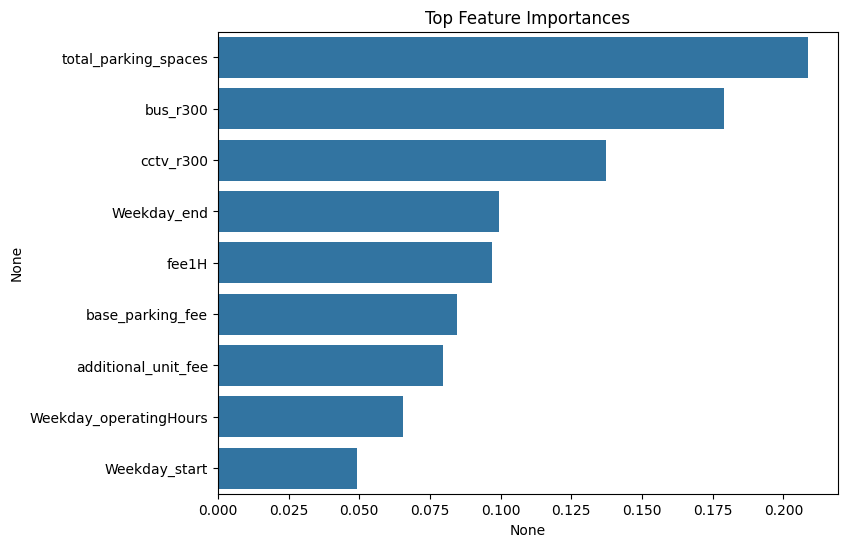

In [12]:
# 변수 중요도 플로팅
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_new.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()